```{index} single: Pyomo; block
```
```{index} single: application; production planning
```
```{index} single: solver; cbc
```
```{index} single: Pyomo; persistent solvers
```
```{index} robust optimization
```
```{index} two-stage problem
```
```{index} constraint and column generation
```

# Two-stage Production Planning

The purpose of this notebook is to demonstrate a range of techniques for two-stage optimization (robust and stochastic) using a range of techniques:
* Robust Optimization (including Constraint and Column Generation)
* Stochastic Optimization (including the SAA method)

In [1]:
# install Pyomo and the cbc solver and import the required packages
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

import numpy as np
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt

pyomo was previously installed
cbc was previously installed


## Problem Statement

Consider again the production planning example from [Chapter 1](../01/01.00.md) where a small startup company has announced the initial production of two models, $U$ and $V$. For completeness we first recall the problem setting and then introduce the additional layer of uncertainty:

* Model $U$ is the higher-priced version requiring 10 units of raw material. The labor requirement is estimated to be 1 hour of labor A and 2 hours of labor B. The $U$ model will sell for 270€ per unit.

* Model $V$ requires 9 units of the same raw materials and is estimated to require 1 hour of labor A and 1 hour of labor B. Model $V$ sells for 210€ per unit with unlimited demand.

* A pre-production  marketing campaign offers guaranteed delivery of model $U$ in return for a down payment. Initially it is expected that the number of such orders will be 20 units. Because of the higher price, the demand for model $U$ is limited so no more than 40 units will be produced.

* The raw materials cost 10€ per unit. The raw materials have a long lead time and must be ordered now. Unused raw materials have no waste value. 

* Given current staffing, there are 80 hours of labor A available at a cost of 50€/hour, and 100 hours of labor B available at a cost of 40€/hour.

* The company will not have not accurate knowledge of the labor required to produce each product until production starts. The estimated amount of labor A and labor B needed for each unit produced could be off by 15% and 25%, respectively. Additionally, there is uncertainty about the amount of down-payment demand for model $U$ -- it can differ by up to 25%, up or down, from the nominal value of 20. It is not expected, however, that more than two of those parameters are perturbed by their maximum amount.

The company's chief operating officer (COO) must decide how much raw material to order now without complete information about the labor needed to manufacture the models or knowledge about the outcome of the pre-production marketing campaign. If the COO orders too much now then raw material will be left over and wasted. If the COO orders too little then a profit opportunity will be lost. In either case, the profit realized will be less than the potential. In what way can the best decision be made?

## Problem description

The problem has a clear two-stage structure: the ordering of the raw material has to be done before the unknown demand is observed and the labor requirements are known. The decisions about the amount of two models to be produced can be, however, made with full information about the uncertainty.

As for the uncertainty itself, no information is given other than the set of values the respective parameters can take:
* $z_A$: Relative uncertainty in the amount of labor A required to produce each unit of product,
* $z_B$: Relative uncertainty is the amount of labor B required to produce each unit of product,
* $z_D$: Uncertainty in number initial orders for product $U$,

where

$$
\begin{align*}
|z_A| & \leq 0.15 && \pm \text{15\% uncertainty in Labor }A \\
|z_B| & \leq 0.25 && \pm \text{25\% uncertainty in Labor }B \\
|z_D| & \leq 0.25 &&  \text{25\% uncertainty in initial orders for }U \\
\end{align*}
$$

and where at most two of them attain their maximum deviation which can be formulated as the following budget constraint:

$$
\begin{align*}
\frac{|z_A|}{0.15} + \frac{|z_A|}{0.25} + \frac{|z_D|}{0.25} \leq 2.
\end{align*}
$$

Let us see how these parameters $z_A$ and $z_B$ affect the problem.  After subtracting the unknown labor cost from the selling price, the unit profit for each device is given by:

$$
\begin{align*}
P_U & = 270 - 50(1+z_A) - 80(1+z_B) - 100) \\
& = 40 - 50 z_A - 80 z_B \\
\implies P_U & \in [2.5, 57.5] \\
\\
P_V & = 210 - 50(1+z_A) - 40(1+z_B) - 90) \\
& = 30 - 50 z_A - 40 z_B \\
\implies P_V  & \in [12.5, 47.5]
\end{align*}
$$

It is therefore not clear in advance which of the products would be more profitable. Taking into account the additional uncertainty about the preorder demand for product $U$, it is not possible to determine in advance what is the worst-case outcome of the uncertainty $z_A$, $z_B$, $z_D$ for this problem.

Since we have no information about the underlying probability distribution of the uncertain parameters, a natural approach is to solve this problem with a worst-case formulation in mind. However, for sake of completeness, we also investigate how the optimal solution would look if each realization of $(z_A, z_B, z_D)$ was equally probable.

## Two-stage problem formulation

We formulate the robust optimization problem where the objective is to maximize the worst-case profit subject to constraints and uncertainty as follows:

$$
\begin{align*}
\max \quad & - 10x + \inf\limits_{\bm{z} \in Z} Q(x, \bm{z}) \\
\text{s.t.} \quad & x \geq 0, 
\end{align*}
$$

where $x$ is the amount of raw material to order, and where the uncertainty $\bm{z} = (z_A, z_B, z_D)$ is given by

$$
\begin{align*}
Z = \left\{ \bm{z}=(z_A, z_B, z_D): \ |z_A| \leq 0.15, \ |z_B| \leq 0.25, \ |z_D| \leq 0.25, \ \frac{|z_A|}{0.15} + \frac{|z_A|}{0.25} + \frac{|z_D|}{0.25} \leq 2 \right\}.
\end{align*}
$$

$Q(x, \bm{z})$ is the second-stage profit defined by

$$
\begin{align*}
Q(x, \bm{z}) = \min \quad & y_3 \\
\text{s.t.}\quad & (140 - 50z_A - 80z_B) y_1 + (120 - 50z_A - 40z_B) y_2 \geq y_3 && \text{(worst-case profit)} \\
& y_1 \geq 20 (1 + z_D) && \text{(pre-production orders)} \\
& y_2 \leq 40 && \text{(maximum demand for $U$)}\\
& (1 + z_A) y_1 + (1 + z_B) y_2 \leq 80 && \text{(labor A)} \\
& 2 (1 + z_A) y_1 + (1 + z_B) y_2 \leq 100 && \text{(labor B)} \\
& -x + 10 y_1 + 9 y_2 \leq 0 && \text{(raw materials)} \\
& y_1, y_2, y_3 \geq 0
\end{align*}
$$

The extra decision variable $y_3$ serves the purpose of keeping the objective of the second-stage problem free of uncertainty. Clearly, $x$ plays the role of the first-stage variable here, whereas $y_1, y_2, y_3$ are the second stage variables. Using our textbook notation, we can formulate the problem data as:

$$
\begin{align*}
x = \begin{pmatrix} x \end{pmatrix},
\
\bm{y} = \begin{pmatrix} y_1 \\ y_2 \\ y_3 \end{pmatrix},
\
\bm{z} = \begin{pmatrix} z_A \\ z_B \\ z_D \end{pmatrix}
\end{align*}
$$

Lastly, we define the data matrices as functions of uncertainties:

$$
\begin{align*}
c = \begin{pmatrix} -10 \end{pmatrix}, \
q = \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix} \\
\end{align*}
$$

$$
\begin{align*}
R(\bm{z})  = \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ -1 \end{pmatrix}, 
\
S(\bm{z}) = \begin{pmatrix} - (140 - 50z_A - 80z_B) & - (120 - 50z_A - 40z_B) & 1 \\ 1 & 0 & 0 \\ 1+z_A & 1 + z_A & 0 \\ 2(1+z_B) & 1 + z_B & 0 \\ 10 & 9 & 0 \end{pmatrix},
\
t(\bm{z}) = \begin{pmatrix} 0 \\ -20(1+z_D) \\ 80 \\ 100 \\ 0 \end{pmatrix} \\
\end{align*}
$$

## Solving the robust problem using sampled scenarios

How can we actually solve such a two-stage problem if it is indeed the worst-case profit that we are interested in? Note that the matrix $S(\bm{z})$ depends on $\bm{z}$ and, therefore, we cannot easily formulate the second-stage decisions as linear functions of $\bm{z}$ (linear decision rules). However, we can generate a finite list of $N$ scenarios and solve a problem that will maximize the worst-case profit across such a set of scenarios:

$$
\begin{align*}
\max \quad & c^\top x + \tau  \\ 
\text{s.t.} \quad  & q^\top y^j \geq \tau, && j = 1, \ldots, N  \\
& R (z^j) x + S(z^j) y^j \leq t(z^j)  &&  j = 1, \ldots, N \\
& x, y^1, \ldots, y^N, \tau \geq 0 
\end{align*}
$$

We first define an auxiliary function that evaluates the system matrix coefficients for a particular scenario $\bm{z} \in Z$ and returns them as nested dictionaries.

In [2]:
# Function to return the vectors and matrices c, q, R, S, t evaluated for a specific realization (z_A, z_B, z_D)


def model_params(z_A=0, z_B=0, z_D=0):
    c = {"x": -10}

    q = {"y1": 0, "y2": 0, "y3": 1}

    R = {
        "profit": {"x": 0},
        "demand": {"x": 0},
        "labor A": {"x": 0},
        "labor B": {"x": 0},
        "raw materials": {"x": -1},
    }

    S = {
        "profit": {
            "y1": -(140 - 50 * z_A - 80 * z_B),
            "y2": -(120 - 50 * z_A - 40 * z_B),
            "y3": 1,
        },
        "demand": {"y1": -1, "y2": 0, "y3": 0},
        "labor A": {"y1": 1, "y2": 1 + z_A, "y3": 0},
        "labor B": {"y1": 2 + 2 * z_B, "y2": 1 + z_B, "y3": 0},
        "raw materials": {"y1": 10, "y2": 9, "y3": 0},
    }

    t = {
        "profit": 0,
        "demand": -20 * (1 + z_D),
        "labor A": 80,
        "labor B": 100,
        "raw materials": 0,
    }

    return c, q, R, S, t


c, q, R, S, t = model_params()

print(f"c = {c}")
print(f"q = {q}")
print(f"R = {R}")
print(f"S = {S}")
print(f"t = {t}")

c = {'x': -10}
q = {'y1': 0, 'y2': 0, 'y3': 1}
R = {'profit': {'x': 0}, 'demand': {'x': 0}, 'labor A': {'x': 0}, 'labor B': {'x': 0}, 'raw materials': {'x': -1}}
S = {'profit': {'y1': -140, 'y2': -120, 'y3': 1}, 'demand': {'y1': -1, 'y2': 0, 'y3': 0}, 'labor A': {'y1': 1, 'y2': 1, 'y3': 0}, 'labor B': {'y1': 2, 'y2': 1, 'y3': 0}, 'raw materials': {'y1': 10, 'y2': 9, 'y3': 0}}
t = {'profit': 0, 'demand': -20, 'labor A': 80, 'labor B': 100, 'raw materials': 0}


We define Pyomo model to maximize the worst-case profit for a set of scenarios, where the block structure is used to repeat the parts of the model which are structurally identical for each outcome of $\bm{z}$.

We then generate $N=1000$ scenarios sampling uniformly at random from the given uncertainty set. We then solve both the nominal problem (inputting a single scenario with the nominal values for the parameters) and the robust problem using $N=1000$ samples. 

In [3]:
# Sample the random variables z_A, z_B, z_D uniformly in the given set
def z_sample(seed):
    rng = np.random.default_rng(seed)
    while True:
        sample = {
            "z_A": 0.15 * rng.uniform(low=-1, high=1),
            "z_B": 0.25 * rng.uniform(low=-1, high=1),
            "z_D": 0.25 * rng.uniform(low=-1, high=1),
        }
        if (
            abs(sample["z_A"]) / 0.15
            + abs(sample["z_B"]) / 0.25
            + abs(sample["z_D"]) / 0.25
            <= 2
        ):
            break
    return sample


# Get a sample of 1000 realizations of the random variables z_A, z_B, z_D
N = 1000
Z = [z_sample(j) for j in range(N)]


# Function to solve the robust problem using the sampled realizations
def max_min_profit(model_params, Z):
    m = pyo.ConcreteModel("Worst case problem")

    # first stage variables
    c, q, *_ = model_params()

    m.I = pyo.Set(initialize=c.keys())
    m.J = pyo.Set(initialize=q.keys())

    m.x = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.tau = pyo.Var()

    m.SCENARIOS = pyo.Set(initialize=range(len(Z)))

    @m.Block(m.SCENARIOS)
    def scenario(b, s):
        # get model parameters for the scenario
        _, q, R, S, t = model_params(**Z[s])

        # second stage variables
        b.y = pyo.Var(b.model().J, domain=pyo.NonNegativeReals)

        @b.Constraint()
        def stage_net_profit(b):
            return b.y["y3"] >= b.model().tau

        @b.Constraint(S.keys())
        def model_constraints(b, k):
            return (
                sum(R[k][i] * b.model().x[i] for i in b.model().I)
                + sum(S[k][j] * b.y[j] for j in b.model().J)
                <= t[k]
            )

    # worst case profit
    @m.Objective(sense=pyo.maximize)
    def worst_case_profit(m):
        return sum(c[i] * m.x[i] for i in m.I) + m.tau

    solver = pyo.SolverFactory("cbc")
    solver.solve(m)
    return m


# Solve the nominal problem
print("\nSolution to the nominal problem")
m = max_min_profit(model_params, [{"z_A": 0, "z_B": 0, "z_D": 0}])
print(f"Objective value: {m.worst_case_profit():.2f}")
print(f"Optimal solution: x = {[pyo.value(m.x[i]) for i in m.I][0]:.2f}")

# Solve the robust problem using the sampled realizations
print("\nSolution to the robust problem using sampling")
m = max_min_profit(model_params, Z)
print(f"Objective value: {m.worst_case_profit():.2f}")
print(f"Optimal solution: x = {[pyo.value(m.x[i]) for i in m.I][0]:.2f}")


Solution to the nominal problem
Objective value: 2600.00
Optimal solution: x = 740.00

Solution to the robust problem using sampling
Objective value: 883.04
Optimal solution: x = 547.81


With the nominal data without any perturbation the optimal quantity of raw material to order is equal to $x^*=740.00$ with a profit of $2600.00$, while for the worst-case profit optimization calculated over $1000$ sampled scenarios, the optimal quantity of raw material to order is equal to $x^*=547.81$ and the worst-case profit is equal to $883.04$. 

## The average-case optimization using SAA

Instead of looking at the worst-case profit, we could be interested in optimizing for the average-case profit, assuming that every scenario within the uncertainty set is equally likely. In this case, we can approximate the optimal solution using the Sample Average Approximation (SAA) method with the same $N=1000$ samples as before. The corresponding optimization model that we are implementing is:

$$
\begin{align*}
\max \limits_{x, y^j} \quad & c^\top x + \frac{1}{N} \sum\limits_{j = 1}^N q^\top y^j \\
\text{s.t.} \quad & A x \leq b \\
& R ( z^j) x + S (z^j) y^j \leq t(z^j) &\  j = 1, \ldots, N.
\end{align*}
$$

The Pyomo implementation is a slight modification of previous worst-case model.

In [4]:
def max_avg_profit(model_params, Z):
    m = pyo.ConcreteModel("Average case problem (using SAA)")

    # first stage variables
    c, *_ = model_params()
    m.I = pyo.Set(initialize=c.keys())
    m.x = pyo.Var(m.I, domain=pyo.NonNegativeReals)

    m.SCENARIOS = pyo.Set(initialize=range(len(Z)))

    @m.Block(m.SCENARIOS)
    def scenario(b, s):
        # get model parameters for the scenario
        _, q, R, S, t = model_params(**Z[s])

        # second stage variables
        b.y = pyo.Var(q.keys(), domain=pyo.NonNegativeReals)

        @b.Constraint(S.keys())
        def model_constraints(b, k):
            return (
                sum(R[k][i] * b.model().x[i] for i in m.I)
                + sum(S[k][j] * b.y[j] for j in q.keys())
                <= t[k]
            )

    # average profit
    @m.Objective(sense=pyo.maximize)
    def avg_profit(m):
        return sum(c[i] * m.x[i] for i in m.I) + sum(
            m.scenario[s].y["y3"] for s in m.SCENARIOS
        ) / len(m.SCENARIOS)

    solver = pyo.SolverFactory("cbc")
    solver.solve(m)
    return m


m = max_avg_profit(model_params, Z)
print(f"Objective value: {m.avg_profit():.2f}")
print(f"Optimal solution: x = {[pyo.value(m.x[i]) for i in m.I][0]:.2f}")

# Store the per-scenario profit realizations into a numpy array
avg_case_ps = np.zeros(len(Z))

for s in range(len(Z)):
    _, q, R, S, t = model_params(**Z[s])
    avg_case_ps[s] = sum(c[i] * m.x[i]() for i in m.I) + m.scenario[s].y["y3"]()

Objective value: 2305.93
Optimal solution: x = 637.08


For this model, the optimal to-order quantity of the raw material changes to $x^*= 637.08$, with the average profit is equal to $2305.93$.

Of course, this is only the comparison of the two approaches by looking at the first-stage decision. One can also be interested in the following two quantities:

* 'average-case performance' of the optimal ordering decision of the robust solution - to find this one, one would need to fix this first-stage decision and for each of the sampled scenarios, one would need to optimize the second-stage decisions, taking the average of their costs in the end. 

* 'worst-case performance' of the optimal ordering decision of the robust solution - to find this, one would need to use a function like the one we used to solve the robust solution, but fixing the first-stage decision to be the one obtained from the stochastic solution.

To do this, we define below a new function similar to the ones above, but which now takes as one of its arguments the fixed first-stage ordering decision and a boolean variable to indicate if we want to optimize for the average or for the worst-case. A careful reader will notice that this function could substitute both of the previous ones combined if the 'first stage decision' argument was made optional.

In [5]:
def max_profit_fixed_x(model_params, Z, fixed_x_value, worst_case=True):
    m = pyo.ConcreteModel()

    # first stage variables
    c, q, *_ = model_params()

    m.I = pyo.Set(initialize=c.keys())
    m.J = pyo.Set(initialize=q.keys())

    m.x = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.tau = pyo.Var()

    m.SCENARIOS = pyo.Set(initialize=range(len(Z)))

    # Fixing the first stage decision
    m.Fixed_x = pyo.Constraint(expr=m.x["x"] == fixed_x_value)

    @m.Block(m.SCENARIOS)
    def scenario(b, s):
        # get model parameters for the scenario
        c, q, R, S, t = model_params(**Z[s])

        # second stage variables
        b.y = pyo.Var(b.model().J, domain=pyo.NonNegativeReals)

        @b.Constraint()
        def stage_net_profit(b):
            return b.y["y3"] >= b.model().tau

        @b.Constraint(S.keys())
        def model_constraints(b, k):
            return (
                sum(R[k][i] * b.model().x[i] for i in b.model().I)
                + sum(S[k][j] * b.y[j] for j in b.model().J)
                <= t[k]
            )

    # deciding what do we optimize for based on the worst_case flag variable

    # worst-case minded optimization
    if worst_case:

        @m.Objective(sense=pyo.maximize)
        def profit(m):
            return sum(c[i] * m.x[i] for i in m.I) + m.tau

    # average-case minded optimization
    else:

        @m.Objective(sense=pyo.maximize)
        def profit(m):
            return sum(c[i] * m.x[i] for i in m.I) + sum(
                m.scenario[s].y["y3"] for s in m.SCENARIOS
            ) / len(m.SCENARIOS)

    solver = pyo.SolverFactory("cbc")
    solver.solve(m)
    return m


xopt_rob = 547.81
print(
    f"\nSolving for the average with optimal-worst-case first-stage decision x = {xopt_rob}"
)
m = max_profit_fixed_x(model_params, Z, xopt_rob, worst_case=False)
print(f"Objective value: {m.profit():.2f} (average profit)")

# Extracting the per-scenario realizations of the worst-case optimal solution
worst_case_ps = np.zeros(len(Z))
for s in range(len(Z)):
    c, q, R, S, t = model_params(**Z[s])
    worst_case_ps[s] = (
        sum(c[i] * m.x[i]() for i in c.keys()) + m.scenario[s].y["y3"]()
    )

xopt_avg = 637.08
print(
    f"\nSolving for the worst-case with optimal-average first-stage decision x = {xopt_avg}"
)
m = max_profit_fixed_x(model_params, Z, xopt_avg, worst_case=True)
print(f"Objective value: {m.profit():.2f} (worst-case profit)")


Solving for the average with optimal-worst-case first-stage decision x = 547.81
Objective value: 2140.78 (average profit)

Solving for the worst-case with optimal-average first-stage decision x = 637.08
Objective value: -9.63 (worst-case profit)


To summarize the above results: 

* the robust-minded first-stage solution $x^*=547.81$ has a worst-case performance of $883.04$ and an average performance of $2140.78$, 
* the average-minded first-stage solution $x^*=637.08$ has a worst-case performance of $-9.63$ and an average performance of $2305.93$. 

There is thus a **tradeoff**: some solutions are good on average and underperform when things go very bad, and vice versa. To understand this tradeoff even better, we display the histograms of per-scenario profit performance of the two solutions.

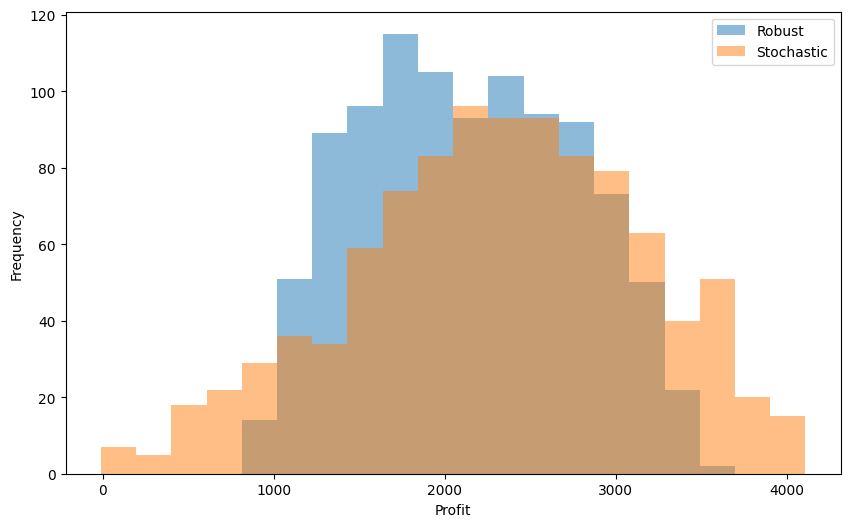

In [6]:
# Collecting the per-scenario optimal values of both the stochastic and robust problems
data = pd.DataFrame({"Robust": worst_case_ps, "Stochastic": avg_case_ps})

# Plotting the results in a histogram
fig, ax = plt.subplots(figsize=(10, 6))
data.plot.hist(bins=20, alpha=0.5, ax=ax)
ax.set_xlabel("Profit")
plt.show()

What we observe is a very typical pattern: the robust solution's 'range' of values is narrower, both in the best- and worst-situation sense, it gives thus stabler profit relations. This comes, however, at the expense of having a worse performance in an 'average' scenario. You can expect to observe this kind of phenomenon very often whenever you need to solve a problem under uncertainty and are unsure whether the worst-case or average-case performance should be optimized for. The degree of tradeoff can help you then make the right decision.

## Column and constraint generation for the robust solution

We now come back to trying to solve for the worst-case solution. The downside of the approach of sampling many scenarios and solving the max-min optimization problem just as before is that it requires really many scenarios to be reasonably sure that we cover most of the extreme outcomes of $z$. This is exactly an issue that the CCG algorithm is supposed to mitigate against - the idea is to gradually build a list of scenarios that are `bad' and hopefully, end up solving a problem with far less than 1000 problem copies included.

In the pessimization step of the CCG, having solved the problem 

$$
\begin{align*}
\max \quad & c^\top x + \tau  \\ 
\text{s.t.} \quad  & q^\top y^j \geq \tau, && j = 1, \ldots, k  \\
& R (z^j) x + S(z^j) y^j \leq t(z^j)  &&  j = 1, \ldots, k \\
& x, y^1, \ldots, y^k, \tau \geq 0 
\end{align*}
$$
for a collection of $k$ realizations, we want to find a new realization $z$ where for each $i$, at least one of the rows in the constraint system

$$
\begin{align*}
C(z^i) \bar{x} + D(z^i) \bar{y}^i \leq e(z^i)
\end{align*}
$$

is violated. If we expand the terms in each of the rows and rewrite the constraints into a form that makes them easier to read as constraints on $z_A$, $z_B$, $z_D$, then we obtain that for each $i$, at least one of the four following has to hold:

$$
\begin{align*}
(50 \bar{y}^i_1 + 50 \bar{y}^i_2) z_A + (80 \bar{y}_1^i + 40 \bar{y}_2^i) z_B & > -\bar{y}^i_3 + 140 \bar{y}^i_1 + 120 \bar{y}^i_2 && \text{(profit)} \\
20 z_D & > \bar{y}_1^i - 20 && \text{(demand)} \\
(y_1^i + y_2^i) z_A & > 80 - \bar{y}_1^i - \bar{y}_2^i && \text{(labor A)} \\
(2 y_1^i + y^i_2) z_B & > 100 - 2 \bar{y}_1^i - \bar{y}_2^i && \text{(labor B)} \\
\end{align*}
$$

Using a sufficiently large number $M$ and binary variables $u_{ik} \in \{0, 1\}$ for each of them, we can formulate the problem of searching for an infeasible scenario as

$$
\begin{align*}
\max \quad & \theta \\
\text{s.t.} \quad &  (50 \bar{y}^i_1 + 50 y_2) z_A + (80 \bar{y}^i_1 + 40 \bar{y}^i_2) z_B - \theta \geq -\bar{y}_3^i + 140 \bar{y}_1^i + 120 \bar{y}_2^i - M u_{i1} && \forall j \\
& 20 z_D - \theta \geq \bar{y}_1^i - 20 - M u_{i2} && \forall j \\
& (\bar{y}_1^i + \bar{y}_2^i) z_A - \theta \geq 80 - \bar{y}_1^i - \bar{y}_2^i - M u_{i3} && \forall j \\
& (2 \bar{y}_1^i + \bar{y}^i_2) z_B 100 - 2 \bar{y}_1^i - \bar{y}_2^i  - M u_{i4} && \forall j \\
& \sum_{k = 1}^4 u_{ik} \leq 3 && \forall j \\
& \theta \geq 0 \\
& u_{jk} \in \{ 0, 1\} && \forall j, k
\end{align*}
$$

We first define an auxiliary function that creates the data structures needed as input for the optimization problem.

In [7]:
def subproblem_params(dec):
    Left = {
        "demand": {"z_A": 0, "z_B": 0, "z_D": 20},
        "profit": {
            "z_A": (50 * dec["y1"] + 50 * dec["y2"]),
            "z_B": (80 * dec["y1"] + 40 * dec["y2"]),
            "z_D": 0,
        },
        "labor A": {"z_A": dec["y1"] + dec["y2"], "z_B": 0, "z_D": 0},
        "labor B": {"z_A": 0, "z_B": 2 * dec["y1"] + dec["y2"], "z_D": 0},
    }

    Right = {
        "demand": dec["y1"] - 20,
        "profit": 140 * dec["y1"] + 120 * dec["y2"] - dec["y3"],
        "labor A": 80 - dec["y1"] - dec["y2"],
        "labor B": 100 - 2 * dec["y1"] - dec["y2"],
    }

    return Left, Right

We then implement the pessimization problem, which, for extra flexibility, includes the maximum values of the parameters' deviations and an uncertainty budget $\Gamma$.

Inspecting the implementation below (c.f. the comment 'hack for faster CCG convergence'), one can notice that in fact we look for scenarios $z$ that will make only the 'feasibility' constraints of the second-stage problem violated, without accounting for the 'profit related' proxy constraint. The reason for doing this is to (possibly) accelerate the CCG convergence - the profit constraint will be taken care of anyway as the variable $y_3$ can adapt freely for each newly generated $z^i$ and each newly generated solution to the master problem, and at the same time, we eliminate the risk of iteratively building a list of scenarios $z$ that violate only the profit constraints across all $i$, without actually hurting the feasibility of the production plans made.

In [8]:
def pessimization_problem(
    subproblem_params,
    master_solution,
    z_A_max=0.15,
    z_B_max=0.25,
    z_D_max=0.5,
    Gamma=2,
):
    # Initial definitions
    m = pyo.ConcreteModel()
    big_M = 1000

    L, R = subproblem_params(master_solution[0])

    # indices for the variables
    m.Z_INDICES = pyo.Set(initialize=["z_A", "z_B", "z_D"])

    # indices for the scenarios
    m.SCENARIOS = pyo.Set(initialize=range(len(master_solution)))

    m.z = pyo.Var(m.Z_INDICES, domain=pyo.Reals)
    m.z_abs = pyo.Var(m.Z_INDICES, domain=pyo.NonNegativeReals)

    m.theta = pyo.Var(domain=pyo.Reals)

    # Constraints on z itself
    m.A_ub = pyo.Constraint(expr=m.z["z_A"] <= z_A_max)
    m.A_lb = pyo.Constraint(expr=-m.z["z_A"] <= z_A_max)
    m.A_abs = pyo.Constraint(expr=m.z["z_A"] <= m.z_abs["z_A"])

    m.B_lb = pyo.Constraint(expr=m.z["z_B"] <= z_B_max)
    m.B_ub = pyo.Constraint(expr=-m.z["z_B"] <= z_B_max)
    m.B_abs = pyo.Constraint(expr=m.z["z_B"] <= m.z_abs["z_B"])

    m.D_lb = pyo.Constraint(expr=m.z["z_D"] <= z_D_max)
    m.D_ub = pyo.Constraint(expr=-m.z["z_D"] <= z_D_max)
    m.D_abs = pyo.Constraint(expr=m.z["z_D"] <= m.z_abs["z_D"])

    m.z_budget = pyo.Constraint(
        expr=m.z_abs["z_A"] / z_A_max
        + m.z_abs["z_B"] / z_B_max
        + m.z_abs["z_D"] / z_D_max
        <= Gamma
    )

    # bounds = {"z_A": (-0.15, 0.15),"z_B": (-0.25, 0.25), "z_D": (-0.5, 0.5)}

    # Constraint violation: blockwise
    @m.Block(m.SCENARIOS)
    def scenario(b, s):
        # get model parameters for the scenario
        L, R = subproblem_params(master_solution[s])

        # second stage variables
        b.u = pyo.Var(L.keys(), domain=pyo.Binary)

        # hack for faster CCG convergence
        @b.Constraint()
        def at_least_one_violated(
            b,
        ):  # only care for violations related to the `actual' constraints, not the profit constraint
            return (
                sum(b.u[k] for k in L.keys() if k != "profit")
                <= len(L.keys()) - 2
            )

        @b.Constraint(L.keys())
        def model_constraints(b, k):
            return (
                sum(L[k][i] * b.model().z[i] for i in b.model().Z_INDICES)
                - b.model().theta
                >= R[k] - b.u[k] * big_M
            )

    # worst case profit
    @m.Objective(sense=pyo.maximize)
    def max_violation(m):
        return m.theta

    solver = pyo.SolverFactory("cbc")
    solver.solve(m)

    return m.theta(), m.z["z_A"](), m.z["z_B"](), m.z["z_D"]()

With the two functions above defined, we are ready to put them together into an implementation of the CCG algorithm. In the below code, we put a hard limit of 50 iterations and we decide to stop the algorithm when the optimal value of the pessimization subproblem is less than 0.1 (constraint violation of 0.1 seems to be "acceptably small" given the fact that the labor availability numbers are in the magnitude of 80 and 100, and the amount of raw material purchased is also expected to be in the hundreds, just like the optimal profit).

In [9]:
ccg_converged = False
stopping_precision = 0.1
max_iterations = 50
ccg_iterations = 0

# Initialize the null scenario - no perturbation
Z = [{"z_A": 0, "z_B": 0, "z_D": 0}]

while (not ccg_converged) and (ccg_iterations < max_iterations):
    # Building and solving the master problem
    m = max_min_profit(model_params, Z)

    # Exporting the data from the master problem into a list of dictionaries
    c, q, *_ = model_params()

    master_solution = []

    print(f"\nIteration #{ccg_iterations}")

    for s in range(len(Z)):
        single_solution = {}

        for x_key in c.keys():
            single_solution[x_key] = m.x[x_key]()

        for y_key in q.keys():
            single_solution[y_key] = m.scenario[s].y[y_key]()

        master_solution.append(single_solution)

    print(f'Current solution: x = {master_solution[0]["x"]:.2f}')

    # Pessimization
    theta_opt, z_A, z_B, z_D = pessimization_problem(
        subproblem_params, master_solution, 0.15, 0.25, 0.25, 2
    )

    # If pessimization yields no violation, stop the procedure, otherwise add a scenario and repeat
    if theta_opt < stopping_precision:
        print("No violation found. Stopping the procedure.")
        ccg_converged = True
    else:
        print(
            f"Violation found: z_A = {z_A:4.2f},  z_B = {z_B:4.2f},  z_D = {z_D:4.2f}"
        )
        print(f"Constraint violation: {theta_opt:6.2f}")
        Z.append({"z_A": z_A, "z_B": z_B, "z_D": z_D})

    ccg_iterations += 1


Iteration #0
Current solution: x = 740.00
Violation found: z_A = 0.15,  z_B = 0.25,  z_D = 0.00, constraint violation:  25.00

Iteration #1
Current solution: x = 560.00
Violation found: z_A = 0.00,  z_B = 0.25,  z_D = 0.25, constraint violation:   5.00

Iteration #2
Current solution: x = 555.61
No violation found. Stopping the procedure.


It takes only two iterations, instead of 1000 scenarios, to arrive at an "almost" robust solution that has essentially the same first-stage decisions as in the first case. 

It really pays off thus to generate scenarios only when they are needed and if they are needed. This principle of "delayed generation of scenarios" has its applications in many fields of large-scale optimization, not just in the context of robustness but even for deterministic problems, where it is known as **column generation** but which is not discussed throughout this book.

## Bibliographic Notes

* Zeng, B., & Zhao, L. (2013). Solving two-stage robust optimization problems using a column-and-constraint generation method. Operations Research Letters, 41(5), 457-461. 